In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e25/sample_submission.csv
/kaggle/input/playground-series-s3e25/train.csv
/kaggle/input/playground-series-s3e25/test.csv


In [37]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import median_absolute_error

from tensorflow import keras
from tensorflow.keras import Model, Sequential, layers, callbacks
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.losses import MeanSquaredError,BinaryCrossentropy,MeanAbsoluteError
from tensorflow.keras.layers import Input, BatchNormalization, Dense
from sklearn.metrics import median_absolute_error as MDE

import tensorflow as tf
import tensorflow_decision_forests as tfdf
import tensorflow_probability as tfp

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [23]:
train = pd.read_csv('/kaggle/input/playground-series-s3e25/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e25/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s3e25/sample_submission.csv')
train.shape, test_df.shape, submission.shape

((10407, 13), (6939, 12), (6939, 2))

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10407 non-null  int64  
 1   allelectrons_Total     10407 non-null  float64
 2   density_Total          10407 non-null  float64
 3   allelectrons_Average   10407 non-null  float64
 4   val_e_Average          10407 non-null  float64
 5   atomicweight_Average   10407 non-null  float64
 6   ionenergy_Average      10407 non-null  float64
 7   el_neg_chi_Average     10407 non-null  float64
 8   R_vdw_element_Average  10407 non-null  float64
 9   R_cov_element_Average  10407 non-null  float64
 10  zaratio_Average        10407 non-null  float64
 11  density_Average        10407 non-null  float64
 12  Hardness               10407 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


In [25]:
train.drop('id', axis=1, inplace=True)

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
dtypes: float64(12)
memory usage: 975.8 KB


In [27]:
X=train
y=train.pop("Hardness")

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
input_shape = X_train.shape[1]
input_shape

11

In [30]:
keras.utils.set_random_seed(42)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=100,
    restore_best_weights=True,
)

In [31]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=[input_shape]),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(2, activation='relu'),
    layers.Dense(1),
])

def loss_fn(y_true, y_pred):
    return tfp.stats.percentile(tf.abs(y_true - y_pred), q=50)

model.compile(
    optimizer='adam',
    loss=loss_fn,
)

In [32]:
history = model.fit(
    X_train.astype('float32'), y_train.astype('float32'),
    validation_data=(X_test.astype('float32'), y_test.astype('float32')),
    epochs=1000,
    callbacks=[early_stopping],
    verbose=1,
)

Epoch 1/1000
228/228 [==============================] - 3s 5ms/step - loss: 2.7959 - val_loss: 1.3114
Epoch 2/1000
228/228 [==============================] - 1s 4ms/step - loss: 1.3669 - val_loss: 1.2034
Epoch 3/1000
228/228 [==============================] - 1s 3ms/step - loss: 1.1724 - val_loss: 0.9921
Epoch 4/1000
228/228 [==============================] - 1s 3ms/step - loss: 1.1171 - val_loss: 1.1311
Epoch 5/1000
228/228 [==============================] - 1s 3ms/step - loss: 1.0639 - val_loss: 0.9542
Epoch 6/1000
228/228 [==============================] - 1s 3ms/step - loss: 1.0206 - val_loss: 0.9694
Epoch 7/1000
228/228 [==============================] - 1s 3ms/step - loss: 0.9490 - val_loss: 0.8743
Epoch 8/1000
228/228 [==============================] - 1s 3ms/step - loss: 0.9439 - val_loss: 0.8563
Epoch 9/1000
228/228 [==============================] - 1s 3ms/step - loss: 0.9206 - val_loss: 0.9326
Epoch 10/1000
228/228 [==============================] - 1s 3ms/step - loss: 0.883

In [33]:
history.history

{'loss': [2.7958524227142334,
  1.3669072389602661,
  1.1724263429641724,
  1.117079496383667,
  1.0638681650161743,
  1.0206164121627808,
  0.949005663394928,
  0.9439333081245422,
  0.9206464290618896,
  0.8833072781562805,
  0.8653051853179932,
  0.8609058260917664,
  0.8265947103500366,
  0.8352959156036377,
  0.809270977973938,
  0.7971001863479614,
  0.7536590695381165,
  0.7562346458435059,
  0.7641839981079102,
  0.7663087248802185,
  0.783679723739624,
  0.7569563388824463,
  0.7316824793815613,
  0.7430740594863892,
  0.756721019744873,
  0.7229130864143372,
  0.709589421749115,
  0.7089440226554871,
  0.7108208537101746,
  0.723564624786377,
  0.7205905914306641,
  0.6989206671714783,
  0.698663592338562,
  0.7132435441017151,
  0.7083713412284851,
  0.7044989466667175,
  0.6879324913024902,
  0.7004584074020386,
  0.7060400247573853,
  0.6920091509819031,
  0.6871242523193359,
  0.6858147382736206,
  0.6836903095245361,
  0.7012783288955688,
  0.6967699527740479,
  0.684027

Minimum validation loss: 0.561367392539978


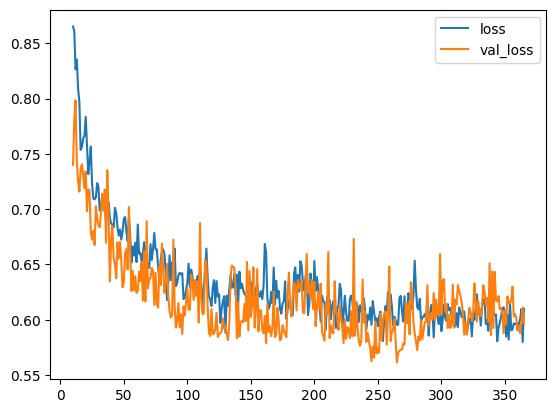

In [34]:
history_df = pd.DataFrame(history.history)[10:]
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [38]:
predictions = model.predict(X_test.astype('float32'))
MDE(predictions, y_test)

98/98 [==============================] - 0s 1ms/step


0.4626977920532225

In [39]:
test = pd.read_csv('/kaggle/input/playground-series-s3e25/test.csv')

In [40]:
test.pop('id')

0       10407
1       10408
2       10409
3       10410
4       10411
        ...  
6934    17341
6935    17342
6936    17343
6937    17344
6938    17345
Name: id, Length: 6939, dtype: int64

In [41]:
test_pred = model.predict(test.astype('float32'))
test_pred

217/217 [==============================] - 0s 1ms/step


array([[2.6706128],
       [3.056188 ],
       [5.804997 ],
       ...,
       [5.849101 ],
       [2.7056413],
       [2.315938 ]], dtype=float32)

In [42]:
sample= pd.read_csv('/kaggle/input/playground-series-s3e25/sample_submission.csv')
sample.head(5)

,id,Hardness
0,10407,4.647
1,10408,4.647
2,10409,4.647
3,10410,4.647
4,10411,4.647


In [43]:
sample["Hardness"] = model.predict(test.astype('float32'))
sample.to_csv("20231123_NNPredictionV1.csv", index=False, header=True)

217/217 [==============================] - 0s 2ms/step
